# Introduction

The City of San Diego was $2.1 billion in debt as of 2020 (see [2020 Financial State of Cities report](https://www.truthinaccounting.org/library/doclib/Financial-State-of-the-Cities-2020.pdf)).  A Strong Towns approach to mitigating this debt would be to avoid developing contiguous urban centers with relatively high liabilities and low assessment values.  Value-per-area maps below may help city planners understand which development patterns minimize liabilities and generate relatively high tax revenue for the city.

# References

* Strong Towns Member Leads a DIY Value Per Acre Analysis - <https://www.strongtowns.org/journal/2019/10/11/strong-towns-member-leads-a-diy-value-per-acre-analysis> ([archive link](https://web.archive.org/web/20211127151939/https://www.strongtowns.org/journal/2019/10/11/strong-towns-member-leads-a-diy-value-per-acre-analysis))
* Value Per Acre Analysis forum post, Strong Town San Diego forum - <https://forum.strongtownsandiego.org/viewtopic.php?f=2&t=628> ([archive link](https://web.archive.org/web/20200808212412/https://forum.strongtownsandiego.org/viewtopic.php?f=2&t=628))


In [172]:
# Extract all relevant GIS archives downloaded from the SanGIS/SANDAG GIS Data
# Warehouse (San Diego's Regional GIS Data Source)

import zipfile
import os

SHAPEFILES = {
    "parcels": {
        "downloaded_archive": "san_diego_data/downloads/Parcels.zip",
    },
    "municipal_boundaries": {
        "downloaded_archive": "san_diego_data/downloads/Municipal_Boundaries.zip",
    },
    "council_districts": {
        "downloaded_archive": "san_diego_data/downloads/Council_Districts.zip",
    },
    "zoning": {
        "downloaded_archive": "san_diego_data/downloads/ZONING_BASE_SD.zip",
    },
    "landuse": {
        "downloaded_archive": "san_diego_data/downloads/LANDUSE_CURRENT.zip",
    },
    "shoreline": {
        "downloaded_archive": "san_diego_data/downloads/SCal.zip",
        "shapefile_name": "Socal_1998.shp",
    },
}

# All the extracted data files will be created underneath.
SHAPEFILES_ROOT_DIR = "san_diego_data/shapefiles"

# Extract all the shapefile archives specified by SHAPEFILES above.
for dataset_name, dataset_paths in SHAPEFILES.items():
    with zipfile.ZipFile(dataset_paths["downloaded_archive"], "r") as zip_ref:
        outputs_path = os.path.join(SHAPEFILES_ROOT_DIR, dataset_name)
        if "shapefile_name" in dataset_paths.keys():
            shapefile_path = os.path.join(outputs_path, dataset_paths["shapefile_name"])
        else:
            # Find the first .shp file and use it.
            shapefile_archive_member = [m for m in zip_ref.namelist() if m.lower().endswith('.shp')][0]
            shapefile_path = os.path.join(outputs_path, shapefile_archive_member)
        # update the SHAPEFILES dictionary to help downstream code find the shapefile.
        dataset_paths["shapefile"] = shapefile_path
        # Finally, extract the zip archives, but only if we haven't already.
        if not os.path.exists(shapefile_path):
            shapedata = zip_ref.extractall(path=outputs_path)

In [243]:
# Create a `parcels` geodataframe containing all taxable parcels in the municipality under question.
# This cell can take tens of minutes to calculate depending on your computer.

import os
import geopandas as gpd

FORCE_RECALCULATE = False

# Load and cleanup the municipal boundaries.
municipal_boundaries = gpd.read_file(SHAPEFILES['municipal_boundaries']['shapefile']).to_crs(epsg=4326)
# remove the encapsulating county boundary.
municipal_boundaries = municipal_boundaries[municipal_boundaries["CODE"] != "CN"]
# remove the duplicate entries by selecting only the most up-to-date versions
municipal_boundaries = municipal_boundaries.groupby(["CODE"]).apply(lambda x: x.sort_values(by=['UPDATEDDAT']).head(1))

municipal_configs = {
    code: {}
    for code in municipal_boundaries["CODE"]
}

# Configure overrides for each municipality.
municipal_configs["SD"].update({
    "xlim": (-117.30, -116.98),
    "ylim": (32.66, 33.07),
})

for municipal_code, municipal_config in municipal_configs.items():
    municipal_name = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["NAME"].str.title()[0]
    municipal_config["parcels_cache_path"] = f"working_layers/parcels_clipped_{municipal_code}.shp"

    if os.path.exists(municipal_config["parcels_cache_path"]) and not FORCE_RECALCULATE:
        ## If the cache file already exists, we can simply load that file instead of recalculating
        ## the municipal parcels which is slow.
        #print(f"Loading cached layer for minicipality {municipal_code} ({municipal_name})...")
        #parcels = gpd.read_file(municipal_config["parcels_cache_path"]).to_crs(epsg=4326)
        print(f"Skip recalculating cache layer for minicipality {municipal_code} ({municipal_name}).")
    else:
        print(f"Recalculating parcels layer for minicipality {municipal_code} ({municipal_name})...")
        parcels = gpd.read_file(SHAPEFILES['parcels']['shapefile']).to_crs(epsg=4326)

        # Limit parcels to the ones which claim to be in the current municipality, according to the jurisdiction field.
        parcels = parcels[parcels["SITUS_JURI"] == municipal_code]

        # There are still a few leftover anomalous parcels way outside the municipal boundary, so
        # further scope down the parcels by using the municipal boundary as a clipping mask.
        municipal_boundary = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["geometry"]
        parcels = gpd.clip(parcels, municipal_boundary, keep_geom_type=True)

        # Finally, save the parcels
        print(f"Saving parcels layer for municipality {municipal_code} ({municipal_name})...")
        parcels.to_file(municipal_config["parcels_cache_path"])

        print(f"Saved parcels layer for municipality {municipal_code} ({municipal_name}).")

Skip recalculating cache layer for minicipality CB (Carlsbad).
Skip recalculating cache layer for minicipality CO (Coronado).
Skip recalculating cache layer for minicipality CV (Chula Vista).
Skip recalculating cache layer for minicipality DM (Del Mar).
Skip recalculating cache layer for minicipality EC (El Cajon).
Skip recalculating cache layer for minicipality EN (Encinitas).
Skip recalculating cache layer for minicipality ES (Escondido).
Skip recalculating cache layer for minicipality IB (Imperial Beach).
Skip recalculating cache layer for minicipality LG (Lemon Grove).
Skip recalculating cache layer for minicipality LM (La Mesa).
Skip recalculating cache layer for minicipality NC (National City).
Skip recalculating cache layer for minicipality OC (Oceanside).
Skip recalculating cache layer for minicipality PW (Poway).
Skip recalculating cache layer for minicipality SD (San Diego).
Skip recalculating cache layer for minicipality SM (San Marcos).
Skip recalculating cache layer for mi

Saved renders/all_parcels_CB.jpg
Saved renders/all_parcels_CO.jpg
Saved renders/all_parcels_CV.jpg
Saved renders/all_parcels_DM.jpg
Saved renders/all_parcels_EC.jpg
Saved renders/all_parcels_EN.jpg
Saved renders/all_parcels_ES.jpg
Saved renders/all_parcels_IB.jpg
Saved renders/all_parcels_LG.jpg
Saved renders/all_parcels_LM.jpg
Saved renders/all_parcels_NC.jpg
Saved renders/all_parcels_OC.jpg
Saved renders/all_parcels_PW.jpg
Saved renders/all_parcels_SD.jpg


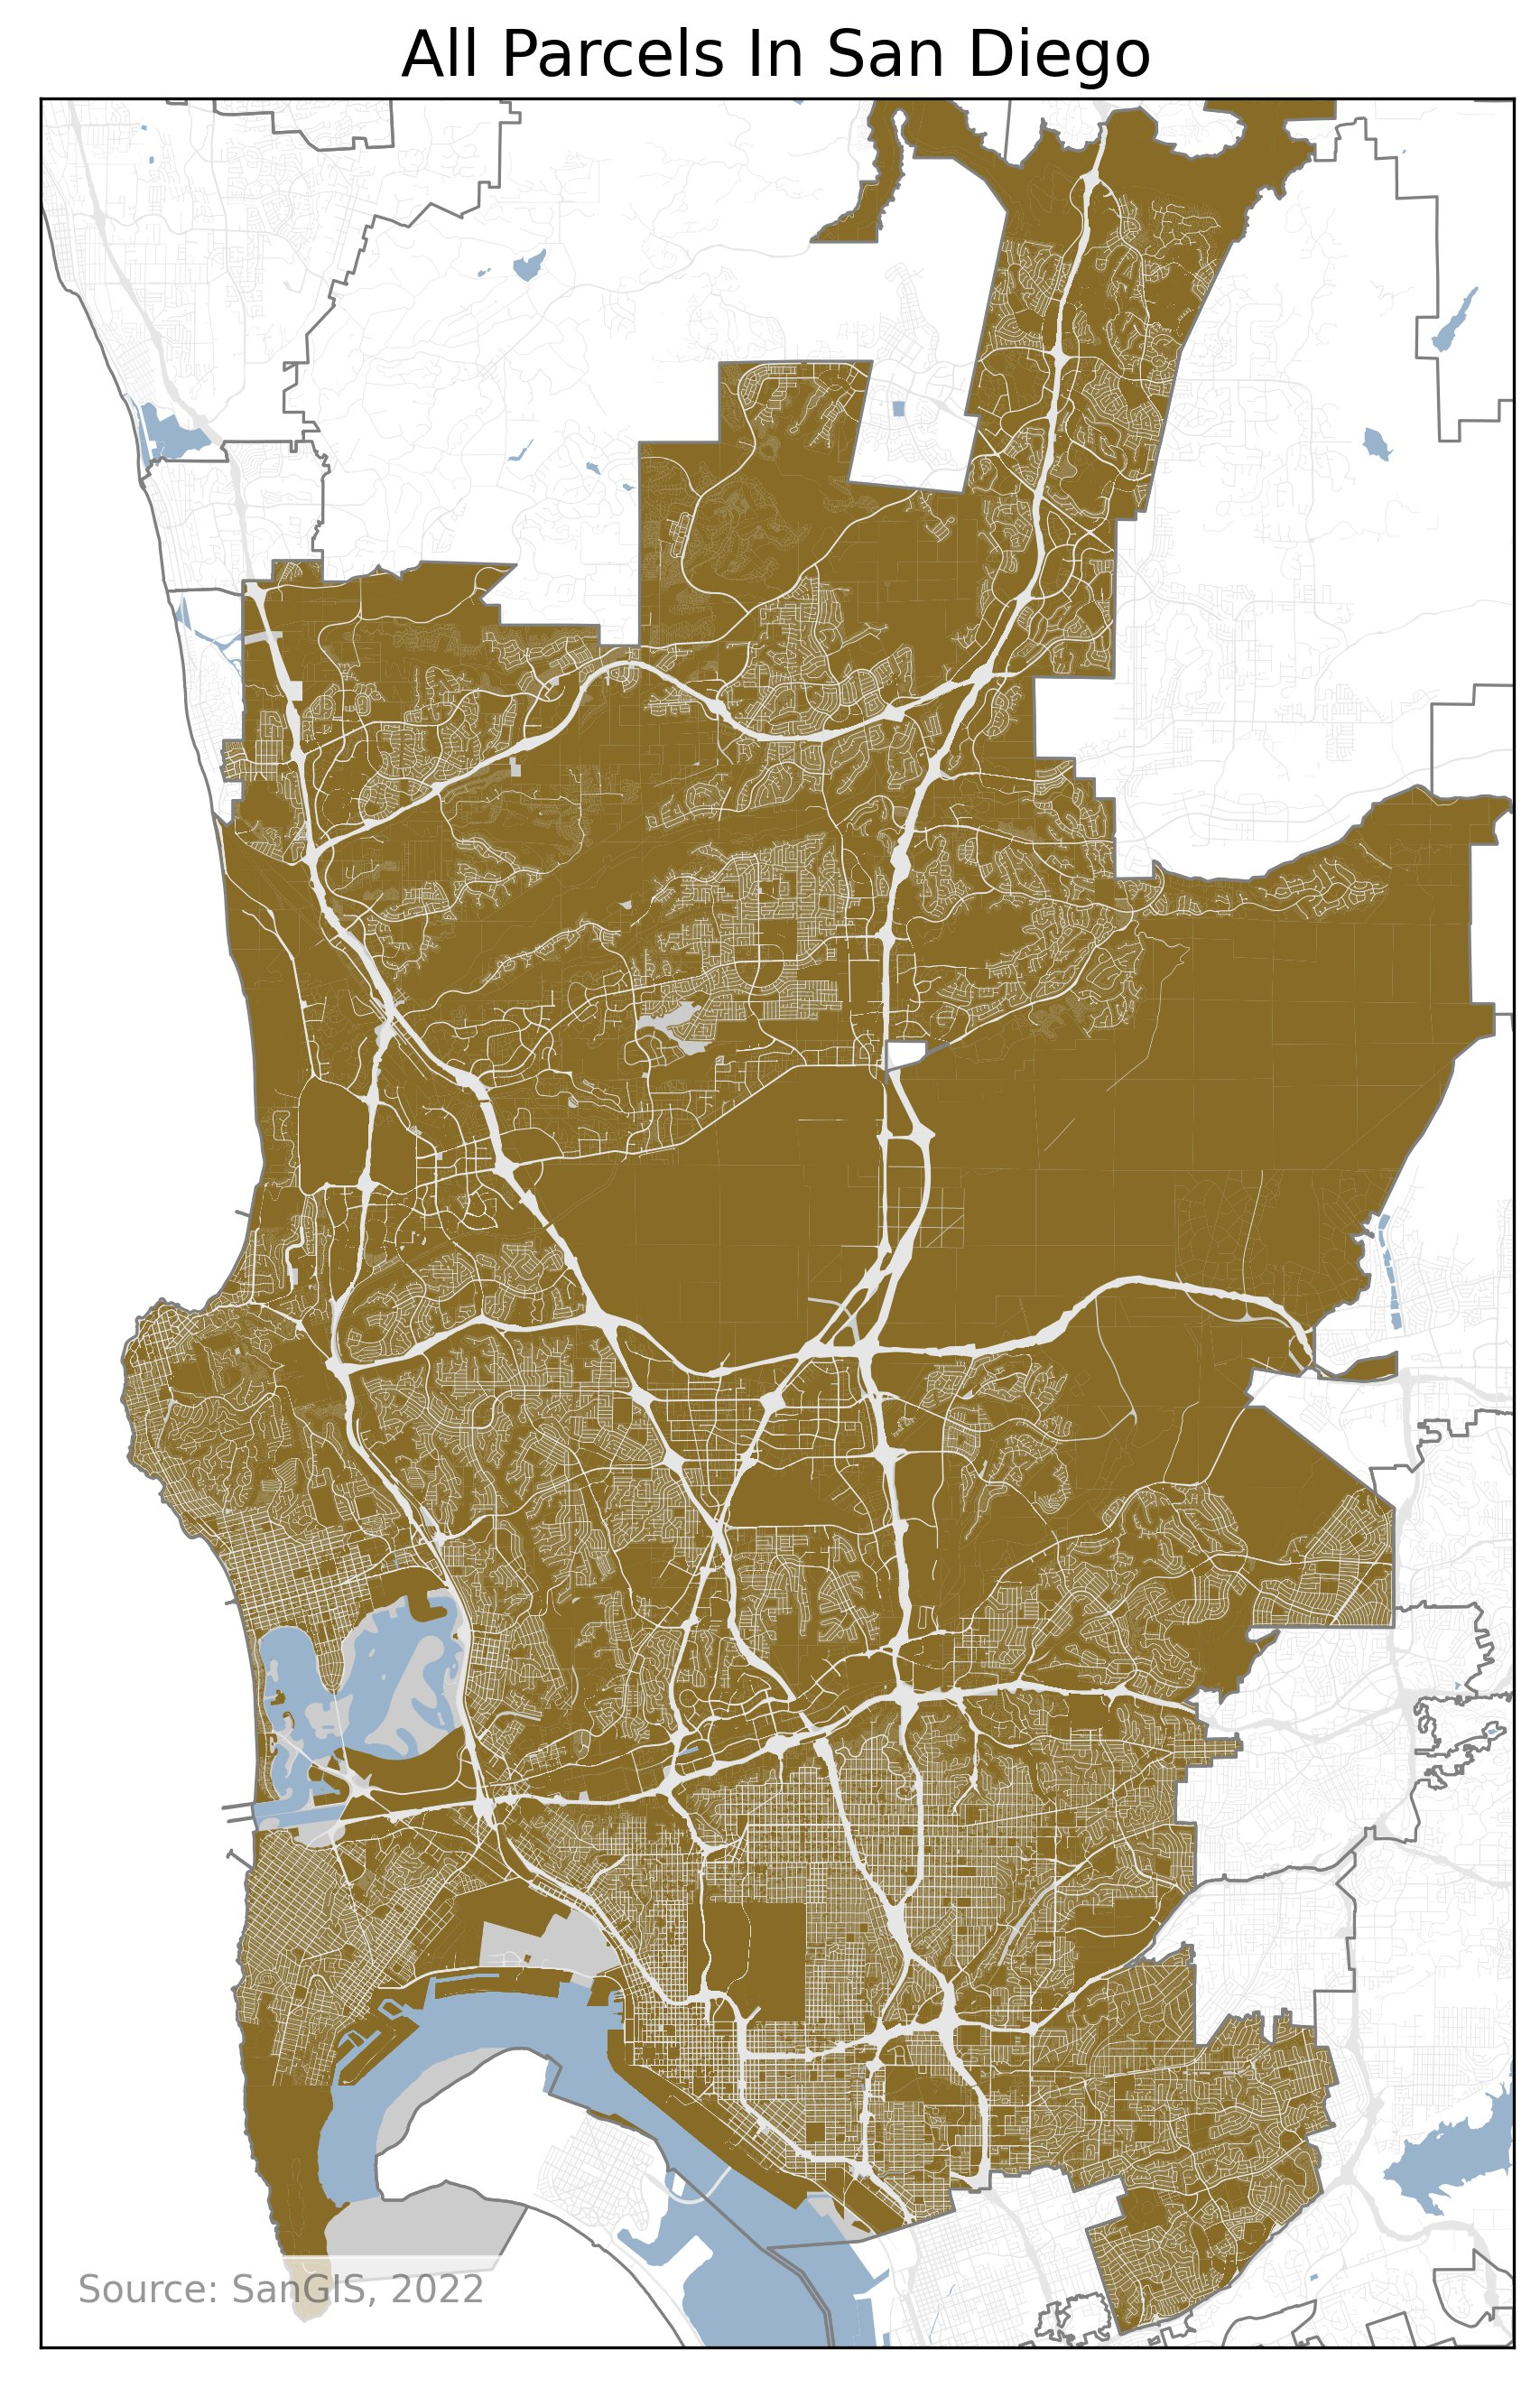

Saved renders/all_parcels_SM.jpg
Saved renders/all_parcels_SO.jpg
Saved renders/all_parcels_ST.jpg
Saved renders/all_parcels_VS.jpg


In [286]:
# Just to get started, plot ALL the taxable parcels in San Diego municipality.  This covers all land uses
# including resedential, commercial, industrial, etc.

import matplotlib.pyplot as plt
from IPython.display import Image, display


# Pull in the landuse dataset so that we can draw local features.  Land use codes are defined here:
# https://www.sandag.org/resources/maps_and_gis/gis_downloads/downloads/codes/land_use_codes.html
landuse = gpd.read_file(SHAPEFILES['landuse']['shapefile']).to_crs(epsg=4326)
roads = landuse[landuse["lu"].isin((
    4112, # Freeway
    4118, # Road Right of Way
))]
water = landuse[landuse["lu"].isin((
    9202, # Lake/Reservoir/Large Pond
    9201, # Bay or Lagoon
))]

for municipal_code, municipal_config in municipal_configs.items():
    municipal_name = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["NAME"].str.title()[0]
    
    # Load parcels for the current municipality from the cache file.
    parcels = gpd.read_file(municipal_config["parcels_cache_path"]).to_crs(epsg=4326)
    
    municipal_boundary = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["geometry"]

    # Plot all parcels.
    fig, ax = plt.subplots(figsize = (8.5,11))
    municipal_boundary.plot(ax=ax, facecolor=(.8, .8, .8, 1))
    roads.plot(ax=ax, color=(0.9, 0.9, 0.9))
    water.plot(ax=ax, color=(0.6, 0.7, 0.8))
    parcels.plot(ax=ax, color=(0.53, 0.42, 0.15))
    municipal_boundaries.plot(ax=ax, facecolor=(0, 0, 0, 0), edgecolor=(.5, .5, .5), linewidth=0.8)
    ax.set_title(f"All Parcels In {municipal_name}", fontdict = {"fontsize": 17})
    if municipal_config and "xlim" in municipal_config:
        # We have configured some custom limits for this municipality.
        ax.set_xlim(*municipal_config["xlim"])
        ax.set_ylim(*municipal_config["ylim"])
    else:
        # Assume that we just want to use the extent of the municipal boundary as the plot limits.
        ax.set_xlim([municipal_boundary.total_bounds[0],  municipal_boundary.total_bounds[2]])
        ax.set_ylim([municipal_boundary.total_bounds[1],  municipal_boundary.total_bounds[3]])
    fig.set_dpi(300.0)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.annotate(
        "Source: SanGIS, 2022",
        xy=(10, 10),
        xycoords="axes points",
        horizontalalignment="left",
        verticalalignment="bottom",
        fontsize=10,
        color=(0.2, 0.2, 0.2, 0.5),
        backgroundcolor=(1, 1, 1, 0.7),
    )
    out_filename = f"renders/all_parcels_{municipal_code}.jpg"
    jpeg_args = {"optimize": True, "quality": 90}
    plt.savefig(out_filename, bbox_inches="tight", pil_kwargs=jpeg_args, dpi=300)
    print(f"Saved {out_filename}")
    plt.close()
    
    if municipal_code == "SD":
        display(Image(filename=out_filename))
        
    # Free memory to make room for next batch of parcels.
    del parcels

Saved renders/price_per_living_area_CB.jpg
Saved renders/price_per_living_area_CO.jpg
Saved renders/price_per_living_area_CV.jpg
Saved renders/price_per_living_area_DM.jpg
Saved renders/price_per_living_area_EC.jpg
Saved renders/price_per_living_area_EN.jpg
Saved renders/price_per_living_area_ES.jpg
Saved renders/price_per_living_area_IB.jpg
Saved renders/price_per_living_area_LG.jpg
Saved renders/price_per_living_area_LM.jpg
Saved renders/price_per_living_area_NC.jpg
Saved renders/price_per_living_area_OC.jpg
Saved renders/price_per_living_area_PW.jpg
Saved renders/price_per_living_area_SD.jpg


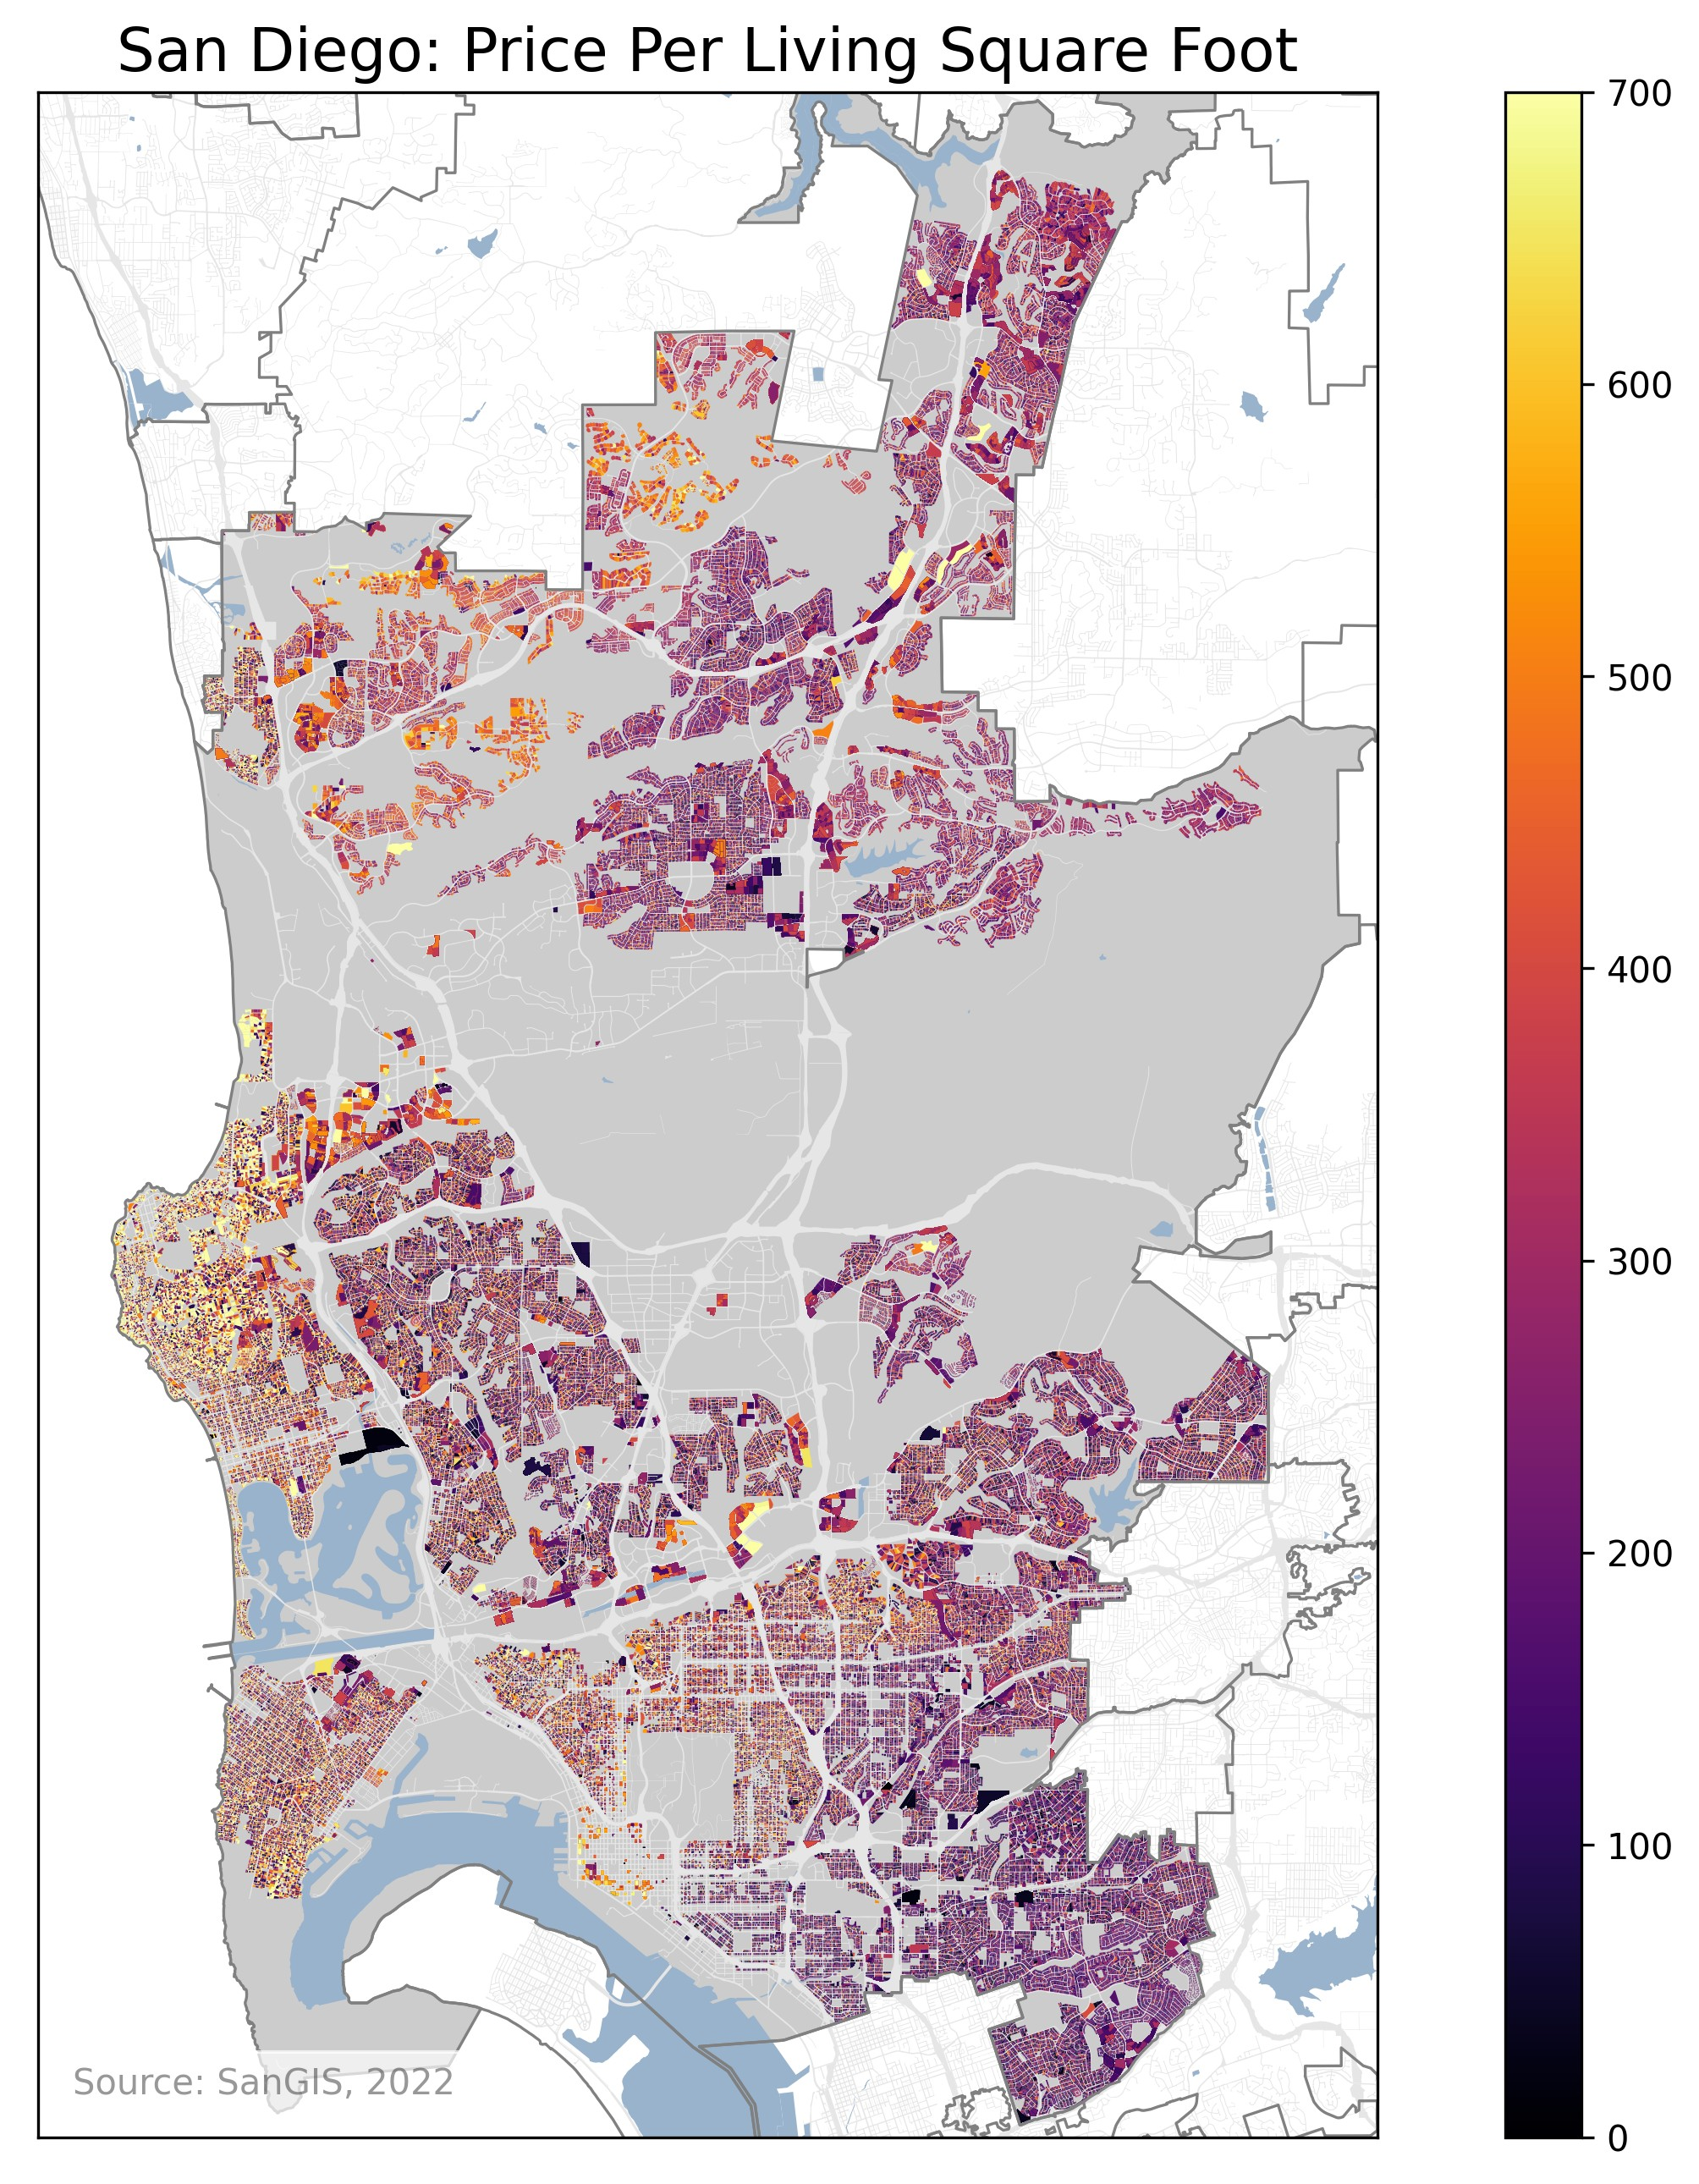

Saved renders/price_per_living_area_SM.jpg
Saved renders/price_per_living_area_SO.jpg
Saved renders/price_per_living_area_ST.jpg
Saved renders/price_per_living_area_VS.jpg


In [287]:
# This is the price per living square foot of all resedential parcels.  This takes into account the
# "living" square foot amount for each parcel, which is the sum of the living area of all floors of all
# structures, including ADUs.  I think this doesn't take into account garages, even if they are attached.
#
# This is different than Zillow's "Zestimate" which I think only takes into account the lot area,
# instead of the living area.

import matplotlib.pyplot as plt
from IPython.display import Image, display


# Pull in the landuse dataset so that we can draw local features.  Land use codes are defined here:
# https://www.sandag.org/resources/maps_and_gis/gis_downloads/downloads/codes/land_use_codes.html
landuse = gpd.read_file(SHAPEFILES['landuse']['shapefile']).to_crs(epsg=4326)
roads = landuse[landuse["lu"].isin((
    4112, # Freeway
    4118, # Road Right of Way
))]
water = landuse[landuse["lu"].isin((
    9202, # Lake/Reservoir/Large Pond
    9201, # Bay or Lagoon
))]

# zone code definitions are documented in Parcels.pdf
RESIDENTIAL_ZONE_CODES = [
    "10", # SINGLE FAMILY RESIDENTIAL
    "20", # MINOR MULTIPLE
    "21", # RESTRICTED MINOR MULTIPLE
    "30", # RESTRICTED MULTIPLE
    "31", # RESTRICTED RESTRICTED MULTIPLE
    "40", # MULTIPLE RESIDENTIAL
    "41", # RESTRICTED MULTIPLE RESIDENTIAL
]

for municipal_code, municipal_config in municipal_configs.items():
    municipal_name = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["NAME"].str.title()[0]
    
    # Load parcels for the current municipality from the cache file.
    parcels = gpd.read_file(municipal_config["parcels_cache_path"]).to_crs(epsg=4326)
        
    # Exclude everything that isn't residential.
    parcels = parcels[parcels["NUCLEUS_ZO"].isin(RESIDENTIAL_ZONE_CODES)]
    
    # Calculate the metric we care about.
    parcels["ASR_VALUE_PER_LVG_AREA"] = parcels["ASR_TOTAL"] / parcels ["TOTAL_LVG_"]

    municipal_boundary = municipal_boundaries[municipal_boundaries["CODE"] == municipal_code]["geometry"]

    # Start to create plot.
    fig, ax = plt.subplots(figsize = (8.5,11))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.3, pad=0.0)

    # Plot all the layers
    municipal_boundary.plot(ax=ax, facecolor=(.8, .8, .8, 1))
    roads.plot(ax=ax, color=(0.9, 0.9, 0.9))
    water.plot(ax=ax, color=(0.6, 0.7, 0.8))
    parcels.plot(
        column="ASR_VALUE_PER_LVG_AREA",
        ax=ax,
        cax=cax,
        cmap="inferno",
        vmin=0,
        vmax=700,
        legend=True
    )
    municipal_boundaries.plot(ax=ax, facecolor=(0, 0, 0, 0), edgecolor=(.5, .5, .5), linewidth=0.8)

    # Configure the rest of the figure parameters. 
    ax.set_title(f"{municipal_name}: Price Per Living Square Foot", fontdict = {"fontsize": 17})
    if municipal_config and "xlim" in municipal_config:
        # We have configured some custom limits for this municipality.
        ax.set_xlim(*municipal_config["xlim"])
        ax.set_ylim(*municipal_config["ylim"])
    else:
        # Assume that we just want to use the extent of the municipal boundary as the plot limits.
        ax.set_xlim([municipal_boundary.total_bounds[0],  municipal_boundary.total_bounds[2]])
        ax.set_ylim([municipal_boundary.total_bounds[1],  municipal_boundary.total_bounds[3]])
    fig.set_dpi(300.0)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.annotate(
        "Source: SanGIS, 2022",
        xy=(10, 10),
        xycoords="axes points",
        horizontalalignment="left",
        verticalalignment="bottom",
        fontsize=10,
        color=(0.2, 0.2, 0.2, 0.5),
        backgroundcolor=(1, 1, 1, 0.7),
    )
    
    out_filename = f"renders/price_per_living_area_{municipal_code}.jpg"
    jpeg_args = {"optimize": True, "quality": 90}
    plt.savefig(out_filename, bbox_inches="tight", pil_kwargs=jpeg_args, dpi=300)
    print(f"Saved {out_filename}")
    plt.close()

    if municipal_code == "SD":
        display(Image(filename=out_filename))

    # Free memory to make room for next batch of parcels.
    del parcels